# Start of actual analysis

Previous Paper: https://pubmed.ncbi.nlm.nih.gov/30334800/ 

used similar dataset, LSTM + 1d-AX + softmax

1d-AX: kinda like windowed mean in A2



Hybrid NN in time domain: https://www.biorxiv.org/content/10.1101/2020.09.20.305300v1.full

In [1]:
import biosig
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt, sosfreqz 

#Xuanyu
data_path = './BCICIV_2b_gdf/'#the folder where all raw data files live

#Can
#data_path = '/Users/canliu/COGS 189/Project'

train_portion = 0.7 #the portion of training data among all the raw data files

# from the data description document
event_start = 4 #the start time point (sec) of imagery for each trial
event_end = 7 #the end time point (sec) of imagery for each trial
bsl_start = 0 #the start time point (sec) of baseline for each trial
bsl_end = 2 #the end time point (sec) of baseline for each trial

files = [os.path.join(data_path, f) for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]
files = [f for f in files if f[-5]=='T']
# for testing purposes only
train_files = files[:5]

# train_files = train_files[:int(len(files)*train_portion)]

## Define functions

In [61]:
def time_ind_conversion(sr, t):
    """
    Convert time in second to the index in the signal array
    """
    return int(np.round(sr*t))


# from A1
def butter_bandpass(lowcut, highcut, fs, order = 2):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order = 2):
        sos = butter_bandpass(lowcut, highcut, fs, order = order)
        y = sosfiltfilt(sos, data)
        return y

def populate_filt_data(files, event_start, event_end, bsl_start, bsl_end, lowcut=7, highcut=30):
    """
    populate and pre-process data for training the model
    
    "It is noted in the literature that while performing any motor imagery tasks, 
    two major frequency band of EEG spectrum i.e mu (7-12 Hz) as well as beta (12-30 Hz) 
    bands are actively involved."
    
    input:
        files: list of file paths to the raw data files
        event_start: the start time point (sec) of imagery for each trial
        event_end: the end time point (sec) of imagery for each trial
        bsl_start: the start time point (sec) of baseline for each trial
        bsl_end: the end time point (sec) of baseline for each trial
        lowcut: lower end of the bandpass filter, default=7Hz
        highcut: higher end of the bandpass filter, default=30Hz
        
    output:
        data: list of eeg signal segments for each imagery 
        label: list of labels for each segment
    
    """
    labels = []
    data = []
    for i in files:
        HDR = json.loads(biosig.header(i))
        sr  = HDR['Samplingrate']
        events = pd.json_normalize(HDR['EVENT'])
        mi_events = events[events.Description.apply(lambda x: 'class' in x)]
        all_data = biosig.data(i).T
        
        for j in mi_events.index:
            t_start = time_ind_conversion(sr, events.POS[j-1]+event_start)
            t_end = time_ind_conversion(sr, events.POS[j-1]+event_end)
            #only use the EEG channels to prevent the model learning EOG patterns
            seg = all_data[:3, t_start:t_end]
            #calculate baseline and trial mean
            t_bsl_start = time_ind_conversion(sr, events.POS[j-1]+bsl_start)
            t_bsl_end = time_ind_conversion(sr, events.POS[j-1]+bsl_end)
            bsl_sig = all_data[:3, t_bsl_start:t_bsl_end]
            bsl = np.nanmean(bsl_sig, 1)
            trial_mean = np.nanmean(seg, 1)
            #preprocess the data by subtract baseline and the trial mean
            seg_after = butter_bandpass_filter((seg.T - bsl - trial_mean).T, lowcut=lowcut, highcut=highcut, fs=sr)
            
            data.append(seg_after)
            labels.append(mi_events.Description[j])
    return data, labels

def reshape_data(data, label):
    x = np.dstack(data)
    x = x.reshape(x.shape[2], x.shape[1], x.shape[0])
    lb = preprocessing.LabelBinarizer()
    y = lb.fit_transform(label)
    return x, y

def create_model(filters=256, pool_size=4, units=64, dropout=0.1, optim='adam'):
    model=Sequential()
    model.add(Conv1D(filters=filters, kernel_size=5, activation = 'relu', input_shape = (750, 3)))
    #model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(units))
    model.add(Dropout(dropout))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    return model



## Build the model

In [49]:
import scipy.io
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Conv1D, MaxPooling1D
from keras.optimizers import SGD, Nadam, Adam, RMSprop
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.decomposition import FastICA
from sklearn.metrics import confusion_matrix

from mne.decoding import CSP
from mne import create_info

import seaborn as sn
import matplotlib.pyplot as plt

### high pass + ICA (remove EOG) + CSP (augmentation)+ 1DConv(feature extraction) + LSTM (sequential learning)

In [ ]:
# This doesn't work... Why?


# train_data, train_label = populate_filt_data(train_files, event_start, event_end, bsl_start, bsl_end)
# data, label = reshape_data(train_data, train_label)
# ica = FastICA(n_components=3)
# all_c3 = data[:,:,0]
# components = ica.fit_transform(all_c3)


In [62]:
# Load data after band-pass filter
train_data, train_label = populate_filt_data(train_files, event_start, event_end, bsl_start, bsl_end)
data, label = reshape_data(train_data, train_label)
train_x, test_x, train_y, test_y = train_test_split(data, label, test_size=0.2, random_state=42)

# TODO: Skip ICA for now because it didn't work

# CSP transformation
csp = CSP(rank={'eeg':3}, transform_into = 'csp_space')
x_new = csp.fit_transform(train_x.reshape(train_x.shape[0], train_x.shape[2], train_x.shape[1]), 
                          np.squeeze(train_y)).reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
x_new_test = csp.fit_transform(test_x.reshape(test_x.shape[0], test_x.shape[2], test_x.shape[1]),
                               np.squeeze(test_y)).reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2])

# plot top CSP filters here

Computing rank from data with rank={'eeg': 3}
    Using tolerance 0.8 (2.2e-16 eps * 3 dim * 1.2e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank={'eeg': 3, 'mag': 3}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank={'eeg': 3, 'mag': 3}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank={'eeg': 3, 'mag': 3}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.


In [63]:
# plot top filters, Doesn't work: No digitization points found.
# info = create_info(ch_names=['C3', 'Cz', 'C4'], sfreq=250.0, ch_types = 'eeg')
# csp.plot_patterns(info=info, ch_type='eeg', sphere=0.095)

In [64]:
# build model here
model = create_model()
model.fit(x_new, train_y, epochs=20, batch_size=50)
model.evaluate(x_new_test, test_y)

Epoch 1/20
12/12 [==============================] - 7s 460ms/step - loss: 0.7007 - accuracy: 0.4877
Epoch 2/20
12/12 [==============================] - 6s 461ms/step - loss: 0.6894 - accuracy: 0.5253
Epoch 3/20
12/12 [==============================] - 6s 458ms/step - loss: 0.6865 - accuracy: 0.5473
Epoch 4/20
12/12 [==============================] - 5s 452ms/step - loss: 0.6761 - accuracy: 0.6088
Epoch 5/20
12/12 [==============================] - 5s 455ms/step - loss: 0.6882 - accuracy: 0.5165
Epoch 6/20
12/12 [==============================] - 6s 465ms/step - loss: 0.6766 - accuracy: 0.5777
Epoch 7/20
12/12 [==============================] - 6s 471ms/step - loss: 0.6701 - accuracy: 0.5863
Epoch 8/20
12/12 [==============================] - 6s 452ms/step - loss: 0.6483 - accuracy: 0.6371
Epoch 9/20
12/12 [==============================] - 6s 470ms/step - loss: 0.6610 - accuracy: 0.6158
Epoch 10/20
12/12 [==============================] - 8s 661ms/step - loss: 0.6330 - accuracy: 0.6725

[0.9117460250854492, 0.5416666865348816]

[Text(33.0, 0.5, 'Predicted'), Text(0.5, 15.0, 'Actual')]

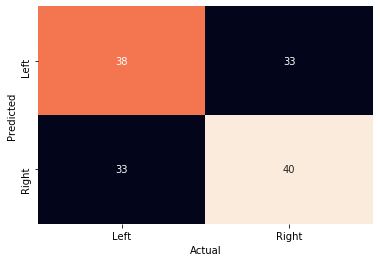

In [65]:
y_pred = model.predict_classes(x_new_test)
cm = confusion_matrix(test_y, np.rint(y_pred))
ax = sn.heatmap(cm, annot=True, cbar=False, xticklabels=['Left', 'Right'], yticklabels=['Left', 'Right'])
ax.set(xlabel='Actual', ylabel='Predicted')

### Train on each individual

Computing rank from data with rank={'eeg': 3}
    Using tolerance nan (2.2e-16 eps * 3 dim * nan  max singular value)
    Estimated rank (mag): 0
    MAG: rank 0 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank={'eeg': 3, 'mag': 0}
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank={'eeg': 3, 'mag': 0}
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank={'eeg': 3, 'mag': 0}
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Epoch 1/10
6/6 [==============================] - 3s 275ms/step - loss: 0.7016 - accuracy: 0.4841
Epoch 2/10
6/6 [==============================] - 2s 283ms/step - loss: 0.6675 - accuracy: 0.6286
Epoch 3/10
6/6 [==============================] - 2s 356ms/step - loss: 0.6643 - accuracy: 0.6129
Epoch 4/10
6/6 [============

2/2 [==============================] - 1s 90ms/step - loss: 0.7057 - accuracy: 0.6667


[Text(33.0, 0.5, 'Predicted'), Text(0.5, 15.0, 'Actual')]

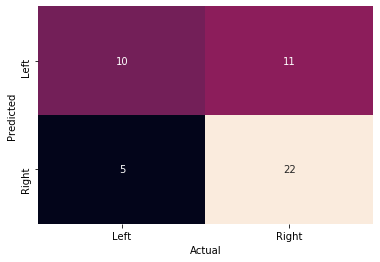

In [69]:
# Load data after band-pass filter
train_data, train_label = populate_filt_data([train_files[0]], event_start, event_end, bsl_start, bsl_end)
data, label = reshape_data(train_data, train_label)
train_x, test_x, train_y, test_y = train_test_split(data, label, test_size=0.3, random_state=42)

# TODO: Skip ICA for now because it didn't work

# CSP transformation
csp = CSP(rank={'eeg':3}, transform_into = 'csp_space')
x_new = csp.fit_transform(train_x.reshape(train_x.shape[0], train_x.shape[2], train_x.shape[1]), 
                          np.squeeze(train_y)).reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
x_new_test = csp.fit_transform(test_x.reshape(test_x.shape[0], test_x.shape[2], test_x.shape[1]),
                               np.squeeze(test_y)).reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2])
model = create_model()
model.fit(x_new, train_y, epochs=10, batch_size=20)
model.evaluate(x_new_test, test_y)

y_pred = model.predict_classes(x_new_test)
cm = confusion_matrix(test_y, np.rint(y_pred))
ax = sn.heatmap(cm, annot=True, cbar=False, xticklabels=['Left', 'Right'], yticklabels=['Left', 'Right'])
ax.set(xlabel='Actual', ylabel='Predicted')

## CSP-LDA baseline model

In [55]:
csp = CSP(n_components=4, rank={'eeg':3})
x_new = csp.fit_transform(train_x.reshape(train_x.shape[0], train_x.shape[2], train_x.shape[1]), 
                          np.squeeze(train_y))
x_new_test = csp.fit_transform(test_x.reshape(test_x.shape[0], test_x.shape[2], test_x.shape[1]),
                               np.squeeze(test_y))
lda = LinearDiscriminantAnalysis(solver = 'lsqr')
lda.fit(x_new, train_y)
lda.score(x_new_test, test_y)

Computing rank from data with rank={'eeg': 3}
    Using tolerance 0.8 (2.2e-16 eps * 3 dim * 1.2e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank={'eeg': 3, 'mag': 3}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank={'eeg': 3, 'mag': 3}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank={'eeg': 3, 'mag': 3}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6041666666666666

[Text(33.0, 0.5, 'Predicted'), Text(0.5, 15.0, 'Actual')]

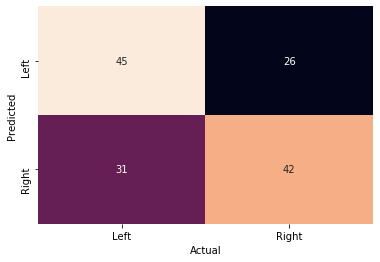

In [57]:
y_pred = lda.predict(x_new_test)
cm = confusion_matrix(test_y, np.rint(y_pred))
ax = sn.heatmap(cm, annot=True, cbar=False, xticklabels=['Left', 'Right'], yticklabels=['Left', 'Right'])
ax.set(xlabel='Actual', ylabel='Predicted')

### On each individual

Computing rank from data with rank={'eeg': 3}
    Using tolerance 0.38 (2.2e-16 eps * 3 dim * 5.7e+14  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank={'eeg': 3, 'mag': 3}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank={'eeg': 3, 'mag': 3}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank={'eeg': 3, 'mag': 3}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
0.4166666666666667


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[Text(33.0, 0.5, 'Predicted'), Text(0.5, 15.0, 'Actual')]

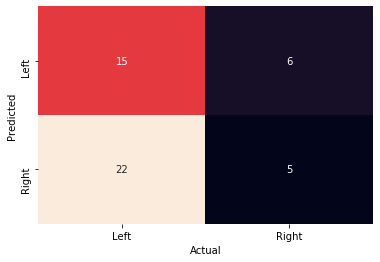

In [72]:
train_data, train_label = populate_filt_data([train_files[0]], event_start, event_end, bsl_start, bsl_end)
data, label = reshape_data(train_data, train_label)
train_x, test_x, train_y, test_y = train_test_split(data, label, test_size=0.3, random_state=42)

csp = CSP(n_components=4, rank={'eeg':3})
x_new = csp.fit_transform(train_x.reshape(train_x.shape[0], train_x.shape[2], train_x.shape[1]), 
                          np.squeeze(train_y))
x_new_test = csp.fit_transform(test_x.reshape(test_x.shape[0], test_x.shape[2], test_x.shape[1]),
                               np.squeeze(test_y))
lda = LinearDiscriminantAnalysis(solver = 'lsqr')
lda.fit(x_new, train_y)
print(lda.score(x_new_test, test_y))

y_pred = lda.predict(x_new_test)
cm = confusion_matrix(test_y, np.rint(y_pred))
ax = sn.heatmap(cm, annot=True, cbar=False, xticklabels=['Left', 'Right'], yticklabels=['Left', 'Right'])
ax.set(xlabel='Actual', ylabel='Predicted')

# Questions for check point 1

1. Remove EOG artifact: Needed? How?
    
2. Another tangent: feasible to include EOG information in the classification? Individual variation too high?
    
3. CSP? Restricted by the number of channels?
    
4. Difference not distinct between averaged signals
    
5. Amplitude much smaller after averaging, also noisier
    
6. preprocesing data: does order matter (DC offset -> filtfilt -> baseline correct); what else needed?


compute C3-C4, C4-C3, or diff with Cz, then bandpass 7-30Hz
take the log of the power (normally distributed)

diff more distinct in freq space

EOG artifact:

ICA (http://www.cogsci.ucsd.edu/academicPubs/igorodni/eog-filtering.pdf)

subtract EOG from EEG? **find code**

## Questions for check point 2

1. accuracy not good... problem with approach?
2. data augmentation? 
    
    "deep convolutional generative adversarial network (DCGAN) provided better augmentation performance than traditional DA methods: geometric transformation (GT), autoencoder (AE), and variational autoencoder (VAE)"
    
    Is CSP a kind of data augmentation? no, but generate better features
    
    Worth trying? time domain: high pass + ICA (remove EOG) + CSP (augmentation)+ 1DConv + max pooling (feature extraction) + LSTM (sequential learning)
    
    try CSP with top 3 filters

Try on 64 channel set

Run model only on EOG to make sure the model is not using eye moving data

Try train on individual data